In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from pathlib import Path
import multiprocessing as mp

from modules.numerical import *

In [3]:
plt.rcParams['axes.labelsize'] = 14

In [4]:
class Config:
    L = 50
    N = int((5/4)*1000)
    dx = 2*L/N
    dt = 0.7*dx

    x_lattice = Lattice(x=(-L, L, dx))
    cm_index = x_lattice.at(x=0)
    collider = KinkCollider(
        x_lattice = x_lattice,
        dt = dt
    )

    v_min = 0.05
    v_max = 0.5
    v_lims = (v_min, v_max)

    lamb_min = 0.075
    lamb_max = 50
    lamb_lims = (lamb_min, lamb_max)

    separation_by_delta = 10

    save_dir = Path('data/new-dataset')
    
    path_format = '%(v)s-%(lamb)s-%(exec_time)s-%(delay)s'

In [16]:
def read_path_info(path: Path) -> dict[str, float]:
    return dict(zip(('v', 'lamb', 'exec_time', 'delay'), map(float, path.stem.split('-'))))

def get_summary(files: tuple[Path]) -> pd.DataFrame:
    return pd.DataFrame([{'path':path, **read_path_info(path)} for path in files])

summary = get_summary(Config.save_dir.glob('*'))
summary

,path,v,lamb,exec_time,delay
0,data/new-dataset/0.3540133779264214-15.6035117...,0.354013,15.603512,6212.099242,21.960698
1,data/new-dataset/0.25016722408026754-6.7539297...,0.250167,6.753930,5162.126230,28.683505
2,data/new-dataset/0.21103678929765884-15.770484...,0.211037,15.770485,3709.034960,26.240957
3,data/new-dataset/0.47591973244147157-11.262207...,0.475920,11.262207,8607.232753,22.343810
4,data/new-dataset/0.4744147157190635-2.91354515...,0.474415,2.913545,10799.342024,26.826434
...,...,...,...,...,...
89994,data/new-dataset/0.2426421404682274-44.4898829...,0.242642,44.489883,3738.297378,25.040899
89995,data/new-dataset/0.3630434782608695-32.4678093...,0.363043,32.467809,5972.148770,23.260959
89996,data/new-dataset/0.27424749163879597-15.269565...,0.274247,15.269565,4897.823551,28.805936
89997,data/new-dataset/0.13578595317725753-11.095234...,0.135786,11.095234,2422.628976,33.774870


In [6]:
def velocity(trail, v_in: bool=True):
    leap = np.argwhere(np.diff(trail) != 0)
    last_leap = leap[-2:]
    output = np.subtract(*trail[last_leap])/(np.subtract(*last_leap)*Config.dt)
    if v_in:
        first_leap = leap[:2]
        output = (np.subtract(*trail[first_leap])/(np.subtract(*first_leap)*Config.dt), output)
    return output

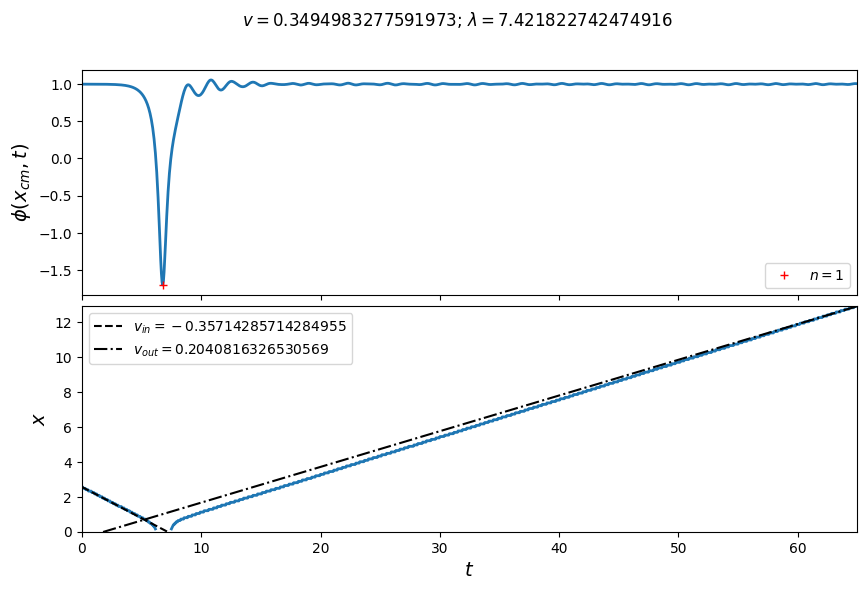

In [8]:
sample = summary.sample(1).iloc[0]
y_cm, trail = np.genfromtxt(sample.path, delimiter=',').T

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'hspace':0.05})

t = np.arange(len(y_cm))*Config.dt
ax1.plot(t, y_cm, lw=2)
ax2.plot(t, trail, lw=2)

peaks, _ = find_peaks(1 - y_cm, prominence=0.5)
ax1.plot(peaks*Config.dt, y_cm[peaks], 'r+', label=r'$n=%s$'%len(peaks))
ax1.legend()

v_in, v_out = velocity(trail)

ax2.plot(t, trail[0] + v_in*t, 'k--', label=r'$v_{in}=%s$'%v_in[0])
ax2.plot(t, trail[-1] + v_out*(t - len(trail)*Config.dt), 'k-.', label=r'$v_{out}=%s$'%v_out[0])
ax2.legend()

ax2.set_ylim(0, np.nanmax(trail))
ax2.set_xlim(0, len(trail)*Config.dt)

fig.suptitle(r'$v={}$; $\lambda={}$'.format(*sample.path.stem.split('-')[:2]))

ax1.set_ylabel(r'$\phi(x_{cm}, t)$')
ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'$x$')
plt.show()

In [9]:
def plot_series_percentile(x, y, percentile: tuple=(5, 10, 25), alpha: tuple=(0.2, 0.4, 0.8), 
                           ax: plt.Axes=None, fill_axis: str='y', label_format: str='%(p)s-%(pf)s %%', **kwargs) -> None:
    if ax == None: ax = plt.gca()
    # plot_function = ax.fill_betweenx  else ax.fill_between
    for p, a in zip(percentile, alpha):
        pf = 100-p
        kwargs['label'] = label_format%{'p':str(p), 'pf':str(pf)}
        kwargs['alpha'] = a
        match fill_axis:
            case 'x': ax.fill_betweenx(y, np.percentile(x, pf, axis=0), np.percentile(x, p, axis=0), **kwargs)
            case 'y': ax.fill_between(x, np.percentile(y, pf, axis=0), np.percentile(y, p, axis=0), **kwargs)

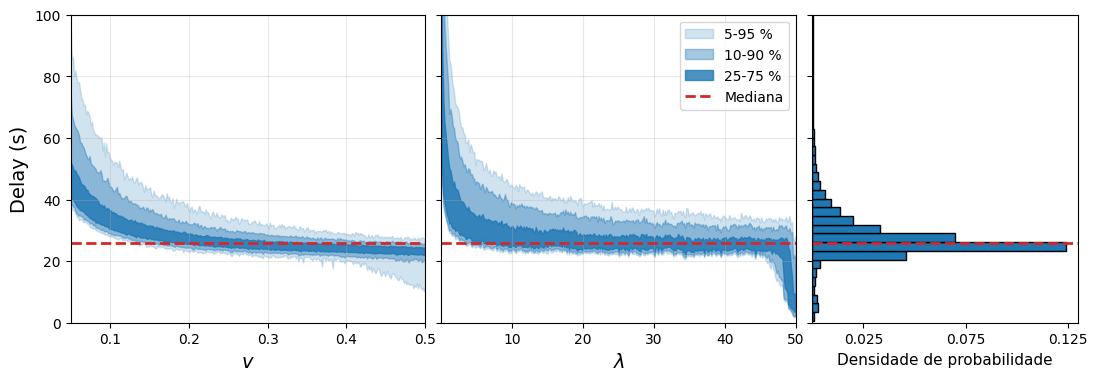

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharey=True, gridspec_kw={'wspace': 0.05, 'width_ratios':[2, 2, 1.5]})

x_label = {'v': r'$v$', 'lamb': r'$\lambda$'}
for col, ax in zip(('v', 'lamb'), axs):
    X = np.sort(summary[col].unique())
    D = np.stack([summary[summary[col] == x].delay.values for x in X]).T

    plot_series_percentile(X, D, ax=ax, color='C0')

    # ax.plot(X, np.median(D, axis=0), 'k-', label='Mediana')
    ax.hlines(summary.delay.median(), X.min(), X.max(), linestyles='dashed', color='C3', lw=2, label='Mediana')

    ax.set_xlim(X.min(), X.max())
    ax.set_xlabel(x_label[col])
    ax.grid(alpha=0.3)

axs[-1].hist(summary.delay, bins=150, density=True, edgecolor='k', orientation='horizontal')
axs[-1].hlines(summary.delay.median(), 0, 0.2, linestyles='dashed', color='C3', lw=2, label='Mediana')
axs[-1].set_xlim(0, 0.13)
axs[-1].set_xticks(axs[-1].get_xticks()[1::2])
axs[-1].set_xlabel('Densidade de probabilidade', fontsize=11)

axs[0].set_ylabel('Delay (s)')
axs[1].set_ylim(0, 100)
axs[1].legend() #bbox_to_anchor=(1.26, 1))

plt.show()

In [47]:
np.prod((3, 3, 3))

27

In [50]:
class ArrayBuilder:
    def __init__(self, dtype: np.dtype, shape: tuple):
        self.dtype = dtype
        self.shape = shape
        self._shared_array = mp.RawArray(np.ctypeslib.as_ctypes_type(dtype), int(np.prod(shape)))
    
    def to_numpy(self):
        return np.frombuffer(self._shared_array, dtype=self.dtype).reshape(self.shape)

    # def constructor(self, function):
    #     def wrapped(*args, **kwargs):
    #         function(self.to_numpy(), *args, **kwargs)
    #     return wrapped

In [61]:
vs = np.linspace(*Config.v_lims, 300)
lambs = np.linspace(*Config.lamb_lims, 300)
len_summary = len(summary)

counter = mp.Value('i', 0)
shared_mosaic = ArrayBuilder(np.float64, (300, 300, 4))
def calc_mosaic(row):
    mosaic = shared_mosaic.to_numpy()
    path, v, lamb = row[:3]
    with counter.get_lock():
        counter.value += 1
        print(f'\r{(counter.value/len_summary*100):.2f}% - v={v} - lamb={lamb}', end='')
    y_cm, trail = np.genfromtxt(path, delimiter=',').T
    i, j = np.squeeze(np.argwhere(vs == v)), np.squeeze(np.argwhere(lambs == lamb))
    v_in, v_out = velocity(trail)
    mosaic[i, j, 0] = y_cm[-1]
    mosaic[i, j, 1] = v_in
    mosaic[i, j, 2] = v_out
    mosaic[i, j, 3] = len(find_peaks(1 - y_cm, prominence=0.5)[0])


with mp.Pool(processes=30) as pool:
    pool.map(calc_mosaic, summary.values)

0.00% - v=0.3540133779264214 - lamb=15.603511705685616

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.00% - v=0.15384615384615385 - lamb=41.985284280936455

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.00% - v=0.25016722408026754 - lamb=6.753929765886287

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.01% - v=0.2697324414715719 - lamb=5.75209030100334484

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.01% - v=0.21103678929765884 - lamb=15.770484949832774

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.01% - v=0.47591973244147157 - lamb=11.262207357859529

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.02% - v=0.23963210702341137 - lamb=22.616387959866216

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.02% - v=0.3043478260869565 - lamb=41.150418060200664

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.02% - v=0.3464882943143813 - lamb=1.2438127090301

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.02% - v=0.4744147157190635 - lamb=2.91354515050167203

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.03% - v=0.24113712374581941 - lamb=31.46596989966555

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.03% - v=0.272742474916388 - lamb=33.4696488294314353

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.03% - v=0.33595317725752505 - lamb=40.816471571906355

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.03% - v=0.35702341137123744 - lamb=26.122826086956525

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.04% - v=0.4834448160535117 - lamb=18.776003344481647

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.05% - v=0.20351170568561872 - lamb=9.4255016722408372

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will erro

0.06% - v=0.12374581939799331 - lamb=14.601672240802673

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.06% - v=0.38561872909698997 - lamb=3.581438127090301

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.07% - v=0.10568561872909699 - lamb=29.462290969899662

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.07% - v=0.44280936454849495 - lamb=48.16329431438127

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.07% - v=0.3946488294314381 - lamb=24.95401337792642

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.07% - v=0.09063545150501673 - lamb=18.275083612040135

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.07% - v=0.2546822742474916 - lamb=16.939297658862873

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.07% - v=0.2682274247491639 - lamb=30.965050167224074

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.08% - v=0.09665551839464884 - lamb=14.935618729096987

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.08% - v=0.30133779264214045 - lamb=47.495401337792636

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.08% - v=0.11471571906354515 - lamb=46.326588628762536

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.09% - v=0.17642140468227424 - lamb=23.785200668896316

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.09% - v=0.2862876254180602 - lamb=30.13018394648829

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.09% - v=0.4879598662207358 - lamb=39.814632107023413

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.09% - v=0.07408026755852842 - lamb=37.810953177257524

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.10% - v=0.05150501672240803 - lamb=42.319230769230764

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.10% - v=0.32391304347826083 - lamb=25.621906354515048

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.11% - v=0.32240802675585284 - lamb=40.649498327759265

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in
/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.11% - v=0.17040133779264216 - lamb=40.482525083612044

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.11% - v=0.05602006688963211 - lamb=32.13386287625418

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.11% - v=0.42625418060200665 - lamb=36.642140468227424

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.12% - v=0.4834448160535117 - lamb=43.65501672240802

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.12% - v=0.1117056856187291 - lamb=33.1357023411371271

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.12% - v=0.13729096989966555 - lamb=30.965050167224074

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.12% - v=0.17040133779264216 - lamb=4.7502508361204014

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.12% - v=0.3931438127090301 - lamb=9.759448160535115

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.13% - v=0.1673913043478261 - lamb=0.9098662207357858

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.13% - v=0.14632107023411373 - lamb=36.30819397993311

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.13% - v=0.37959866220735783 - lamb=45.324749163879595

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.14% - v=0.07859531772575251 - lamb=10.09339464882943

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


0.14% - v=0.31939799331103674 - lamb=17.607190635451502

/tmp/ipykernel_3133566/3869084367.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 1] = v_in


0.14% - v=0.4578595317725752 - lamb=14.267725752508358

/tmp/ipykernel_3133566/3869084367.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mosaic[i, j, 2] = v_out


100.00% - v=0.4187290969899665 - lamb=40.98344481605350625

In [62]:
mosaic = shared_mosaic.to_numpy()
mosaic.shape

(300, 300, 4)

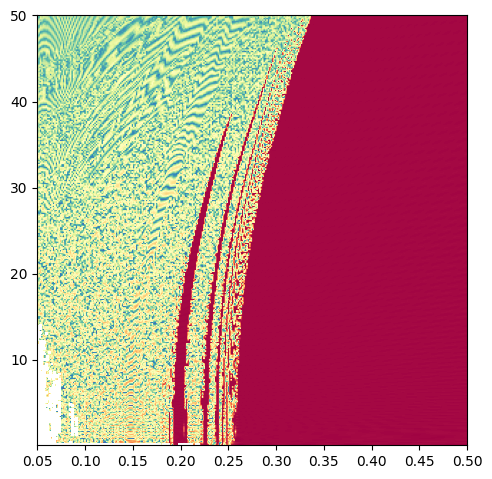

In [80]:
plt.figure(figsize=(5, 5))
plt.imshow(mosaic[..., 0].T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap='Spectral_r', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
)
plt.gcf().tight_layout()
plt.show()

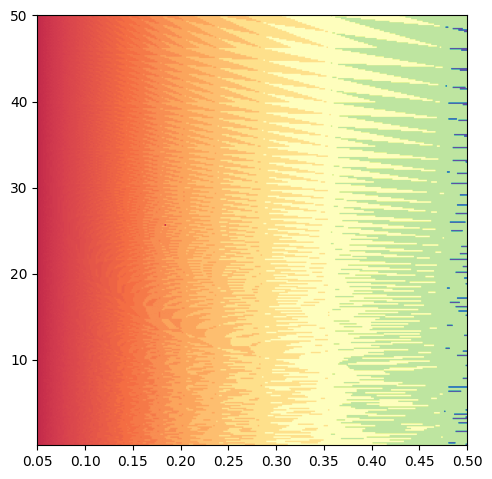

In [81]:
plt.figure(figsize=(5, 5))
plt.imshow(mosaic[..., 1].T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap='Spectral_r', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
)
plt.gcf().tight_layout()
plt.show()

/tmp/ipykernel_3133566/1436565390.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.nan_to_num(mosaic[..., 2].T, nan=999))),


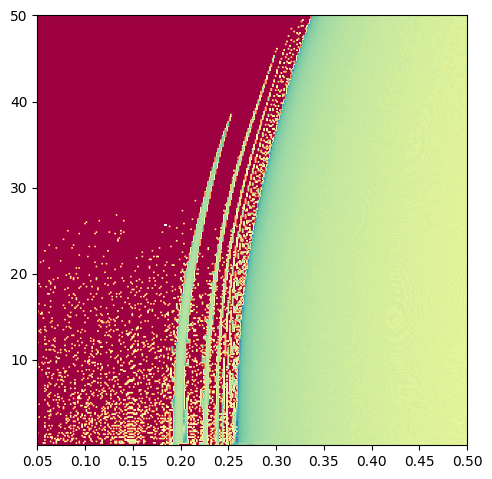

In [82]:
plt.figure(figsize=(5, 5))
plt.imshow(np.log(np.abs(np.nan_to_num(mosaic[..., 2].T, nan=999))), 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap='Spectral_r', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
)
plt.gcf().tight_layout()
plt.show()

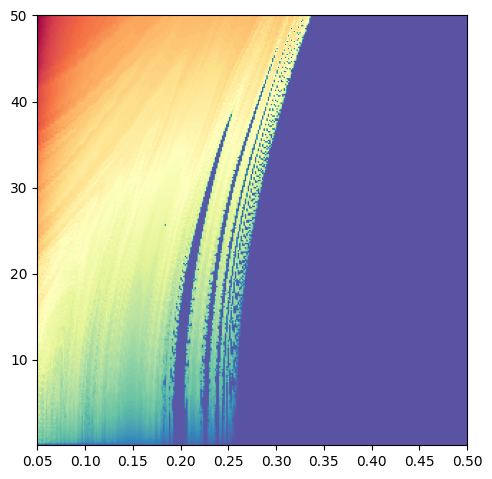

In [107]:
plt.figure(figsize=(5, 5))
plt.imshow(mosaic[..., 3].T, 
    extent=(*Config.v_lims, *Config.lamb_lims), 
    cmap='Spectral_r', 
    aspect=(Config.v_max - Config.v_min)/(Config.lamb_max - Config.lamb_min), 
    origin='lower', 
    resample=False,
)
# plt.contour(mosaic[..., 3].T, levels=(1, 2), colors=('b', 'r'))
plt.gcf().tight_layout()
plt.show()

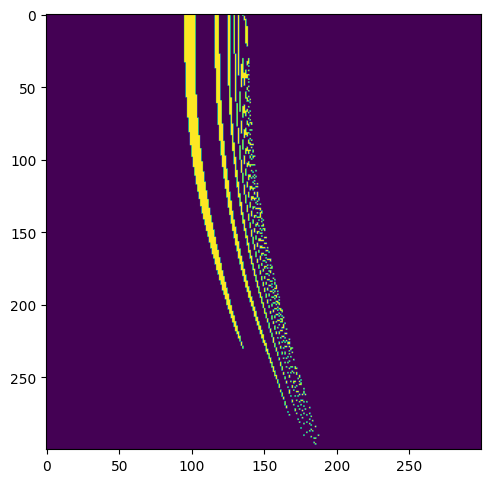

In [110]:
plt.figure(figsize=(5, 5))
plt.imshow(mosaic[..., 3].T == 2)
plt.gcf().tight_layout()
plt.show()

In [14]:
import psutil
import pandas as pd

In [15]:
for k, v in psutil.sensors_temperatures().items(): print(k); print(pd.DataFrame(v))

enp7s0
             label  current  high critical
0  PHY Temperature   63.207  None     None
1  MAC Temperature   69.474  None     None
nvme
       label  current    high  critical
0  Composite    38.85  117.85    149.85
coretemp
           label  current  high  critical
0   Package id 0     59.0  72.0      82.0
1        Core 11     54.0  72.0      82.0
2        Core 16     53.0  72.0      82.0
3        Core 17     53.0  72.0      82.0
4        Core 18     52.0  72.0      82.0
5        Core 19     56.0  72.0      82.0
6        Core 20     55.0  72.0      82.0
7        Core 24     55.0  72.0      82.0
8        Core 25     57.0  72.0      82.0
9        Core 26     54.0  72.0      82.0
10       Core 27     54.0  72.0      82.0
11        Core 0     52.0  72.0      82.0
12        Core 1     51.0  72.0      82.0
13        Core 2     58.0  72.0      82.0
14        Core 3     56.0  72.0      82.0
15        Core 4     56.0  72.0      82.0
16        Core 8     55.0  72.0      82.0
17        Core

In [3]:
def read(filename):
    return pd.read_csv(filename, index_col=0)

def imshow(y, x, t, ax=None, **kwargs):
    (plt if ax == None else ax).imshow(y, extent=(t.min(), t.max(), x.min(), x.max()), origin='lower', **kwargs)

In [4]:
path = Path('data/dataset/')
files = tuple(path.glob('*'))

In [7]:
i = np.random.randint(len(files))
df = read(files[i]).T
y = df.values
t = df.index.values.astype(float)
x = df.columns.values.astype(float)
lat = Lattice()
lat.ranges = [t, x]

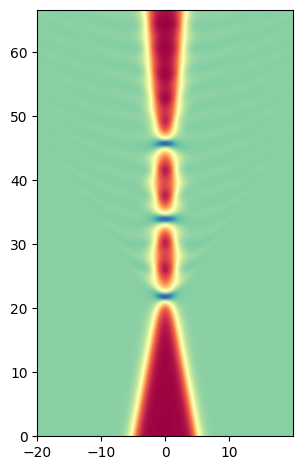

In [24]:
_, wx = lat.window(..., (-20, 20))
imshow(y[:, wx], t, x[wx], cmap='Spectral_r', aspect='equal')

plt.gcf().tight_layout()
plt.show()

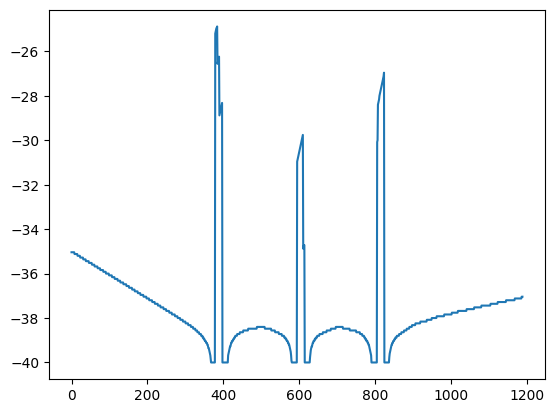

In [66]:
plt.plot([x[np.argmin(np.abs(yi))] for yi in y[:, lat.at(..., 0)[1]:]])

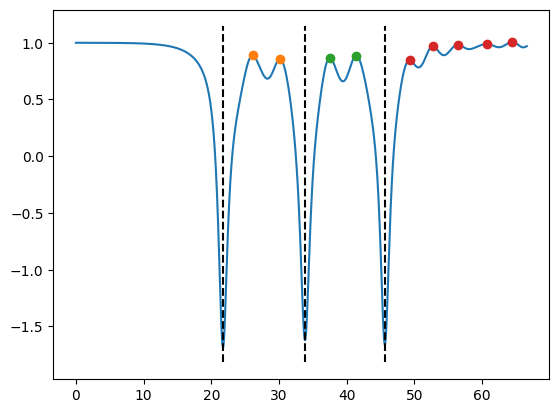

In [25]:
cm = y[*lat.at(..., 0)]
peaks, _ = find_peaks(cm**2, prominence=1.5)

plt.plot(t, cm)
plt.vlines(t[peaks], *plt.gca().get_ylim(), colors='k', linestyles='dashed')

for i in range(len(peaks) - 1):
    bounce = (t > t[peaks][i]) & (t < t[peaks][i+1])
    mini_peaks, _ = find_peaks(cm[bounce])
    plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')
bounce = t > t[peaks][-1]
mini_peaks, _ = find_peaks(cm[bounce])
plt.plot(t[bounce][mini_peaks], cm[bounce][mini_peaks], 'o')

plt.show()

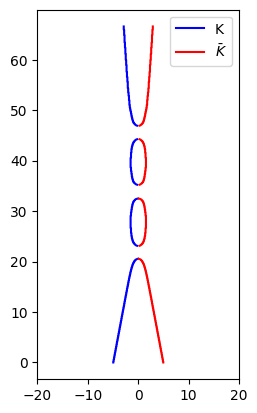

In [26]:
k1, k2 = [], []
for i in range(len(t)):
    x_slice = x[y[i] >= 0]
    if len(x_slice) == 0:
        k1.append(np.nan)
        k2.append(np.nan)
    else:
        k1.append(x_slice.min())
        k2.append(x_slice.max())
k1, k2 = np.r_[k1], np.r_[k2]

plt.plot(k1, t, 'b-', label=r'K')
plt.plot(k2, t, 'r-', label=r'$\bar{K}$')
plt.legend()
plt.gca().set_aspect('equal')
plt.xlim(-20, 20)

plt.show()

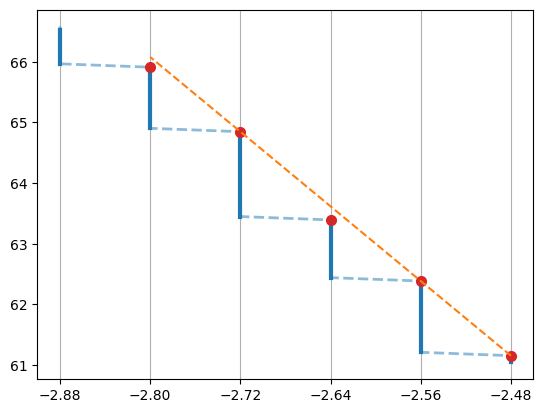

In [27]:
Q = 100
plt.plot(k1[-Q:], t[-Q:], 'C0--', lw=2, alpha=0.5)

vs = np.diff(k1[-Q:])
for slc in np.ma.clump_masked(np.ma.masked_equal(vs, 0)):
    plt.plot(k1[-Q:][slc], t[-Q:][slc], 'C0-', lw=3)

vertex = np.argwhere(vs != 0).ravel()
plt.plot(k1[-Q:][vertex], t[-Q:][vertex], 'C3o', markersize=7) # t = ax + b => b = t - ax

v1, v2 = vertex[:2]
delta_t = -t[-Q:][v2] + t[-Q:][v1]
dx = x[1] - x[0]
a = delta_t/dx

b = t[-Q:][vertex[0]] - k1[-Q:][vertex[0]]*a
X_v = np.linspace(k1[-Q:][vertex[0]], k1[-Q:][vertex[-1]], 25)
plt.plot(X_v, X_v*a + b, 'C1--')

# plt.legend()
plt.grid(axis='x')
k1_unique = np.unique(k1[-Q:])
plt.xticks(k1_unique[~np.isnan(k1_unique)])
plt.show()

2.857142857142749
2.8571428571429305
1.4285714285714648
-0.07518796992481394
-2.857142857142749
-2.8571428571429296
-1.4285714285714648
0.07518796992481436


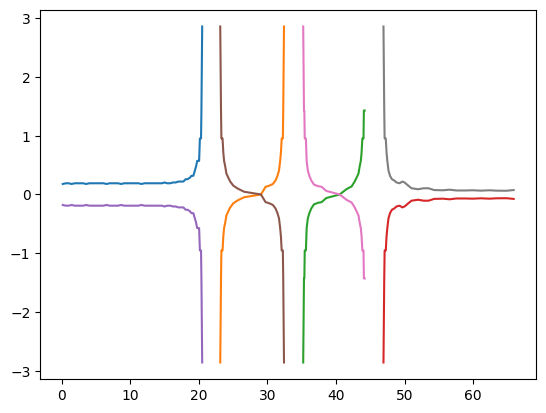

In [47]:
for k in (k1, k2):
    for slc in np.ma.clump_unmasked(np.ma.masked_invalid(k)):
        vertex = np.argwhere(np.diff(k[slc]) != 0)
        V = np.gradient(k[slc][vertex].ravel())/np.gradient(t[slc][vertex].ravel())
        plt.plot(t[slc][vertex].ravel(), V)
        print(V[-1])
plt.show()

In [59]:
c = lat.at(..., 0)[1]
y_lb = y[peaks[-1]:, c:] >= 0
x_lb = lat[1][c:]

x_ve = []
while len(x_ve < ):
    xi_ = x_lb[y_lb[-i]].max()
    if xi_ != xi: break
    else: i += 1

(xi_ - xi)/(lat[0][-i] - lat[0][-1])

0.11904761904762141

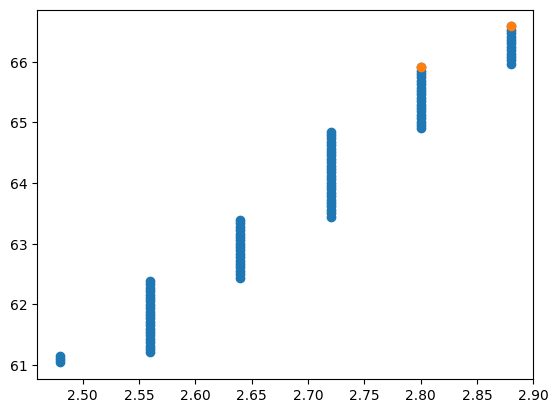

In [61]:
plt.plot(k2[-100:], t[-100:], 'o')
plt.plot((xi_, xi), (lat[0][-i], lat[0][-1]), 'o')

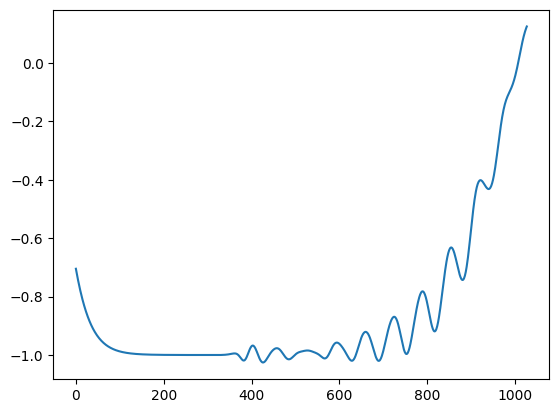

In [19]:
y_dx1 = y[*lat.at(..., k1 + np.diff(lat.ranges[1])[-1])]
plt.plot()

In [11]:
path = Path('data/dataset2')
files = tuple(path.glob('*'))
len(files)

2000

In [12]:
read(files[0])

,y_cm,k
0.000,0.999998,-30.00
0.056,0.999998,-30.00
0.112,0.999998,-30.00
0.168,0.999998,-30.08
0.224,0.999998,-30.08
...,...,...
114.184,1.005624,-28.24
114.240,1.005954,-28.24
114.296,1.006198,-28.16
114.352,1.006354,-28.16


In [13]:
files[0].stem

'0.29079539769884943-1'

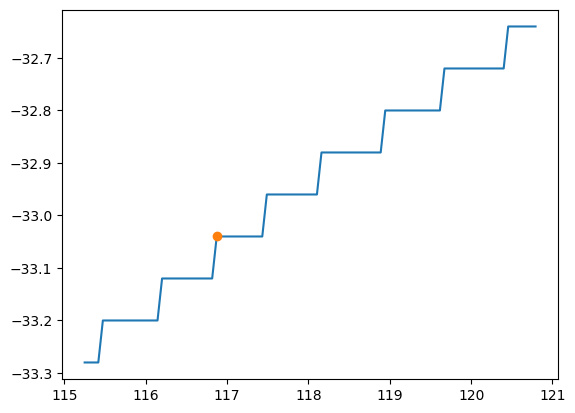

In [14]:
df = read(files[100])
t = df.index.astype(float)
plt.plot(t[-100:], df.k.values[-100:])
vex = np.argwhere(df.k.diff().values[-100:] != 0)
plt.plot(t[-100:][vex[2]], df.k.values[-100:][vex[2]], 'o')

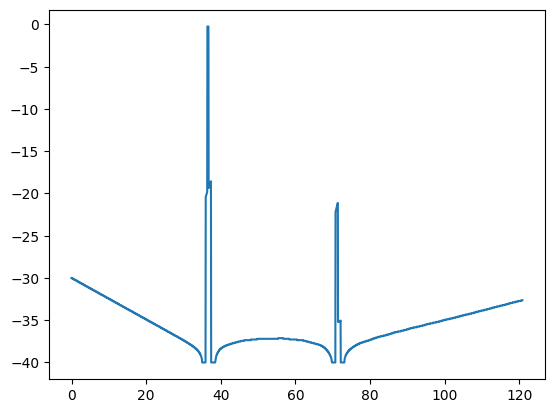

In [15]:
plt.plot(t, df.k)

In [16]:
V = []
N = []
V_out = []

for filename in files:
    V.append(float(filename.stem.split('-')[0]))
    df = read(filename)
    t = df.index.values.astype(float)
    k = df.k.values

    peaks, _ = find_peaks(df.y_cm**2, prominence=1.5)
    N.append(len(peaks))
    
    v = np.argwhere(df.k.diff() != 0)
    V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
    
V = np.r_[V]
N = np.r_[N]
V_out = np.r_[V_out]

/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_5557/644041635.py:15: RuntimeWarning: Mean of empty slice.
  V_out.append(np.abs(np.diff(k[v])/np.diff(t[v])).mean())
/home/jairo/Documentos/GitHub/kink-antikink-parellel/.env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret

Text(0, 0.5, '$N$')

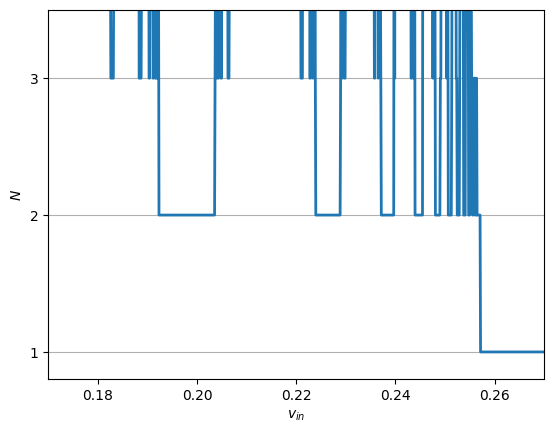

In [22]:
sort = np.argsort(V)
plt.plot(V[sort], N[sort], lw=2)
plt.ylim(0.8, 3.5)
plt.xlim(0.17, 0.27)
plt.yticks([1, 2, 3])
plt.grid(axis='y')
plt.xlabel(r'$v_{in}$')
plt.ylabel(r'$N$')

(0.0, 1.0)

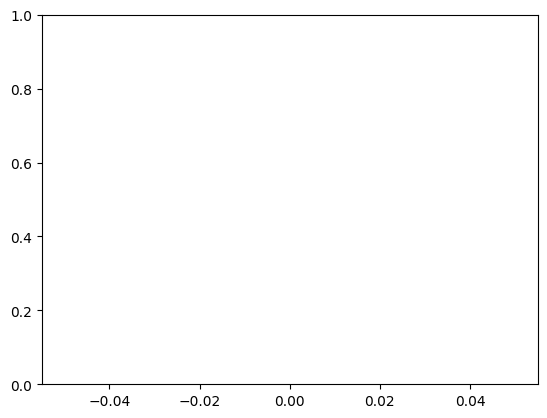

In [95]:
sort = np.argsort(V)
loc = N[sort] == 2
plt.plot(V[sort][loc], V_out[sort][loc], '-')
plt.ylim(0, 1)

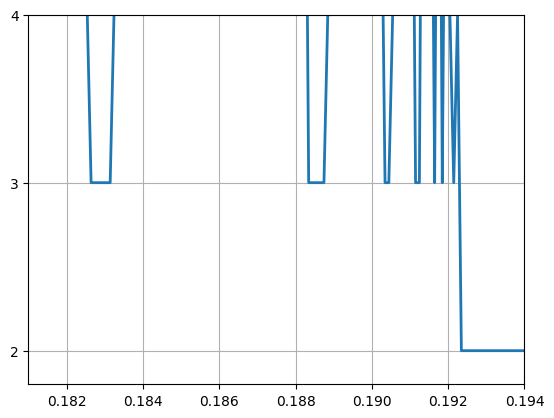

In [74]:
sort = np.argsort(V)
plt.plot(V[sort], N[sort], lw=2)
plt.ylim(1.8, 4)
plt.xlim(0.181, 0.194)
plt.yticks([2, 3, 4])
plt.grid()

In [5]:
from celluloid import Camera
from IPython.display import HTML

def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

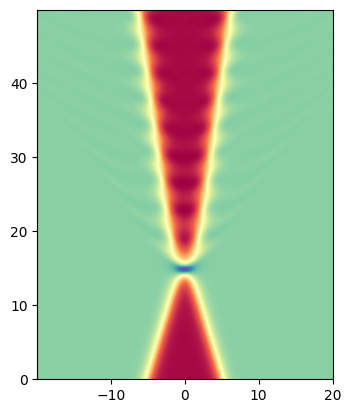

In [9]:
fig = plt.figure()
fig.tight_layout()

camera = Camera(fig)

vs = [float(filename.stem.split('-v:')[-1]) for filename in files]
x = np.arange(-40, 40, 2*40/1000)
w = (x >= -20) & (x <= 20)
for i in np.argsort(vs):
    df = read(files[i]).T
    y = df.values
    t = df.index.values.astype(float)
    loc = t < 50
    imshow(y[loc][:, w], t[loc], x[w], cmap='Spectral_r', aspect='equal')
    camera.snap()

In [10]:
show(camera.animate(interval=10))